In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms

In [3]:
torch.cuda.empty_cache()

# Expériences sur MNIST


Modèles à tester

In [4]:
# Modèle de classification avec plus de couches
class CNN(nn.Module):
    def __init__(self, output_dim=10):
        super(CNN, self).__init__()

        # Définir les couches convolutives
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)  # Images MNIST (1 canal)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        #self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        # Couches fully-connected
        self.fc1 = nn.Linear(64 * 7 * 7, 512)  # Taille après réduction par les convolutions (28x28 -> 3x3 après convolutions et pooling)
        self.fc2 = nn.Linear(512, output_dim)  # 10 classes pour MNIST

        # Couches de pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 + ReLU + Pooling
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 + ReLU + Pooling
        #x = self.pool(F.relu(self.conv3(x)))  # Conv3 + ReLU + Pooling
        x = x.view(-1, 64 * 7 * 7)  # Aplatir les données pour la couche fully-connected
        x = F.relu(self.fc1(x))  # Fully connected 1
        x = self.fc2(x)  # Fully connected 2 (sortie)
        return x

Fonctions utiles

In [5]:
# Fonction pour initialiser le modèle suivant le prior
def initialize_weights(model, mean=0.0, std=1):
    for param in model.parameters():
        if param.requires_grad:  # S'assurer que les paramètres sont appris par le modèle
            init.normal_(param, mean=mean, std=std)

# Fonction pour mettre à jour les paramètres du modèle
def set_model_params(model, theta):
    with torch.no_grad():
        for param, new_param in zip(model.parameters(), theta):
            param.copy_(new_param)

# Fonction de log-probabilité avec prior gaussien
def log_prob_func(model, data, target, prior_std=1.0):
    logits = model(data)
    log_likelihood = -F.cross_entropy(logits, target, reduction='sum')
    prior = -0.5 * sum(torch.sum(p ** 2) for p in model.parameters()) / (prior_std ** 2)
    return log_likelihood + prior

# Fonction pour collecter les gradients
def compute_gradients(model, data, target):
    log_prob = log_prob_func(model, data, target)
    grads = torch.autograd.grad(log_prob, model.parameters(), create_graph=True)
    return grads

# Implémentation de Leapfrog
def leapfrog(theta, r, step_size, num_steps, model, data, target):
    theta = [p.clone().detach().requires_grad_(True) for p in theta]
    r = [ri.clone().detach() for ri in r]

    set_model_params(model, theta)
    grad = compute_gradients(model, data, target)

    for i in range(len(r)):
        r[i] = r[i] + 0.5 * step_size * grad[i]

    for _ in range(num_steps):
        for i in range(len(theta)):
            theta[i] = theta[i] + step_size * r[i]

        set_model_params(model, theta)
        grad = compute_gradients(model, data, target)

        for i in range(len(r)):
            r[i] = r[i] + step_size * grad[i]

    set_model_params(model, theta)
    grad = compute_gradients(model, data, target)

    for i in range(len(r)):
        r[i] = r[i] - 0.5 * step_size * grad[i]

    return theta, r

# Fonction d'acceptation Metropolis-Hastings
def acceptance(theta, r, new_theta, new_r, model, data, target, device):
    set_model_params(model, theta)
    current_H = -log_prob_func(model, data, target) + 0.5 * sum(torch.sum(ri**2) for ri in r)

    set_model_params(model, new_theta)
    proposed_H = -log_prob_func(model, data, target) + 0.5 * sum(torch.sum(ri**2) for ri in new_r)

    accept_prob = torch.exp(current_H - proposed_H)

    if torch.rand(1).to(device) < accept_prob:
        #print(accept_prob)
        return new_theta, 1
    else:
        return theta, 0

# Fonction d'inférence avec la méthode BMA
def bma_inference(model, samples, data, device):
    preds = []
    for sample in samples:
        # Charger les paramètres dans le modèle
        for param, s in zip(model.parameters(), sample):
            param.data = s.data  # Mettre à jour les paramètres du modèle avec l'échantillon

        model.to(device)
        output = model(data)
        preds.append(F.softmax(output, dim=1))  # Utilisation de softmax pour obtenir les probabilités

    # Calcul de la moyenne des prédictions
    avg_preds = torch.stack(preds).mean(0)  # Moyenne sur tous les échantillons (axis 0)

    # Retourner la classe avec la plus haute probabilité
    return avg_preds, avg_preds.argmax(dim=1)

### Génération des samples

In [6]:
# Vérifier si un GPU est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chargement des données MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])  # MNIST est en niveaux de gris

batch_size = 32
# Dataloaders
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, drop_last=True) # drop_last to stack the outputs and target later

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.06MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
def compute_calibration_curve(outputs, labels, num_bins=20):
    """
    Compute the calibration curve and Expected Calibration Error (ECE).

    Parameters:
        outputs (torch.Tensor): Model outputs (probabilities), shape (N, num_classes).
        labels (torch.Tensor): Ground-truth labels, shape (N,).
        num_bins (int): Number of bins for calibration.

    Returns:
        dict: Contains "confidence", "accuracy", "proportions", and "ece".
    """
    # Flatten outputs and labels
    labels = labels.view(-1)  # Ensure labels are 1D
    outputs = outputs.view(labels.size(0), -1)  # Ensure correct shape

    # Get confidences (max probabilities) and predicted classes
    confidences, predictions = torch.max(outputs, dim=1)
    accuracies = (predictions == labels).float()  # Boolean to float (1=correct, 0=incorrect)

    # Sort confidences to determine bin edges
    num_inputs = confidences.shape[0]
    bins = torch.sort(confidences)[0][::(num_inputs + num_bins - 1) // num_bins]
    if num_inputs % ((num_inputs + num_bins - 1) // num_bins) != 1:
        bins = torch.cat((bins, confidences.max().unsqueeze(0)))

    # Initialize bin statistics
    bin_confidences, bin_accuracies, bin_proportions = [], [], []
    ece = 0.0  # Expected Calibration Error

    # Compute calibration metrics for each bin
    for bin_lower, bin_upper in zip(bins[:-1], bins[1:]):
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        prop_in_bin = in_bin.float().mean().item()

        if prop_in_bin > 0:
            accuracy_in_bin = accuracies[in_bin].mean().item()
            avg_confidence_in_bin = confidences[in_bin].mean().item()
            ece += abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

            bin_confidences.append(avg_confidence_in_bin)
            bin_accuracies.append(accuracy_in_bin)
            bin_proportions.append(prop_in_bin)

    # Convert lists to tensors
    return {
        "confidence": torch.tensor(bin_confidences),
        "accuracy": torch.tensor(bin_accuracies),
        "proportions": torch.tensor(bin_proportions),
        "ece": ece
    }


In [8]:
prior_mean, prior_var = 0, 1/5
prior_std = np.sqrt(prior_var)

# Initialisation du modèle et envoi du modèle sur le GPU
model = CNN(output_dim=10).to(device)
initialize_weights(model, mean=0.0, std=prior_std)
theta = [p.clone().detach().to(device) for p in model.parameters()]  # Déplacer les paramètres du modèle sur le GPU

# Hyperparamètres
trajectory_length = (np.pi * prior_std)/2
step_size = 0.0005 # delta
n_leapfrog = 20 #int(trajectory_length // step_size) # paper
n_burnin = 20
n_samples = 200
n_classes = 10


def HMC_sampling(device, model, theta, train_loader, step_size, num_steps, n_burnin, n_samples):
    samples, num_acceptations = [], 0
    
    # Burnin phase
    for _ in tqdm(range(n_burnin), desc="Burn in phase"):
        r = [torch.randn_like(p).to(device) for p in theta]  # momentum
        data, target = next(iter(train_loader))
        data, target = data.to(device), target.to(device)  
    
        theta, r = leapfrog(theta, r, step_size, num_steps, model, data, target) # leapfrog

    
    # Sampling phase
    for _ in tqdm(range(n_samples), desc="Sampling phase"):
        r = [torch.randn_like(p).to(device) for p in theta]  # momentum
        data, target = next(iter(train_loader))
        data, target = data.to(device), target.to(device) 
    
        new_theta, new_r = leapfrog(theta, r, step_size, num_steps, model, data, target) # leapfrog
        
        theta, acceptation = acceptance(theta, r, new_theta, new_r, model, data, target, device)
        num_acceptations += acceptation

        del r, new_theta, new_r
        torch.cuda.empty_cache()
        
        samples.append([p.clone().detach().cpu() for p in theta])  # Save samples
    
    print(f"Sampling finished. {len(samples)} samples with {num_acceptations/n_samples} acceptance_ratio.")
    return samples

samples = HMC_sampling(device, model, theta, train_loader, step_size, n_leapfrog, n_burnin, n_samples)

Sampling phase: 100%|██████████| 200/200 [00:18<00:00, 10.96it/s]

Sampling finished. 200 samples with 0.465 acceptance_ratio.


In [9]:

n_classes = 10
outputs = []
targets = []
model.eval()  # Mettre le modèle en mode évaluation
with torch.no_grad():
  for data, target in tqdm(test_loader, desc="Predicting the test set"):
      data, target = data.to(device), target.to(device)  # Envoyer les données sur le GPU

      # Obtenez les prédictions avec BMA
      preds, avg_pred = bma_inference(model, samples, data, device)

      outputs.append(preds)
      targets.append(target)
outputs = torch.stack(outputs).view(-1, n_classes)
targets = torch.stack(targets).view(-1)

results = compute_calibration_curve(outputs, targets)

print("\nAccuracy : ", results["accuracy"].mean().item())
print("Confidence : ", results["confidence"].mean().item())
print("ECE : ", results["ece"])

log_likelihood = -F.cross_entropy(outputs, targets, reduction='sum')
print("log likelihood : ", log_likelihood.item())


Predicting the test set: 100%|██████████| 312/312 [02:17<00:00,  2.26it/s]



Accuracy :  0.8289204239845276
Confidence :  0.7724199891090393
ECE :  0.05452064217015962
log likelihood :  -17131.275390625


In [10]:
def compute_dataset_log_prob(model, dataloader, prior_std=1.0, device="cuda"):
    """
    Calcule le log prior, log likelihood et log posterior sur tout le dataset.

    Parameters:
        model (torch.nn.Module): Le modèle PyTorch.
        dataloader (torch.utils.data.DataLoader): Le DataLoader du dataset.
        prior_std (float): Écart-type du prior gaussien.
        device (str): "cuda" ou "cpu" selon le matériel.

    Returns:
        dict: Contenant "log_prior", "log_likelihood" et "log_posterior".
    """
    model.eval()  # Met le modèle en mode évaluation (important pour désactiver dropout, batchnorm...)
    log_likelihood_total = 0.0
    total_samples = 0

    # Calcul du log prior (indépendant des données)
    log_prior = -0.5 * sum(torch.sum(p ** 2) for p in model.parameters()) / (prior_std ** 2)

    # Calcul du log likelihood en parcourant tout le dataset
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)  # Déplacement sur le bon device

            logits = model(data)
            log_likelihood = -F.cross_entropy(logits, target, reduction='sum')

            log_likelihood_total += log_likelihood.item()
            total_samples += target.size(0)

    # Normalisation par le nombre d'échantillons pour obtenir une moyenne
    log_likelihood_mean = log_likelihood_total / total_samples
    log_posterior = log_likelihood_mean + log_prior  # Posterior = Prior + Likelihood

    return {
        "log_prior": log_prior.item(),
        "log_likelihood": log_likelihood_mean,
        "log_posterior": log_posterior.item()
    }

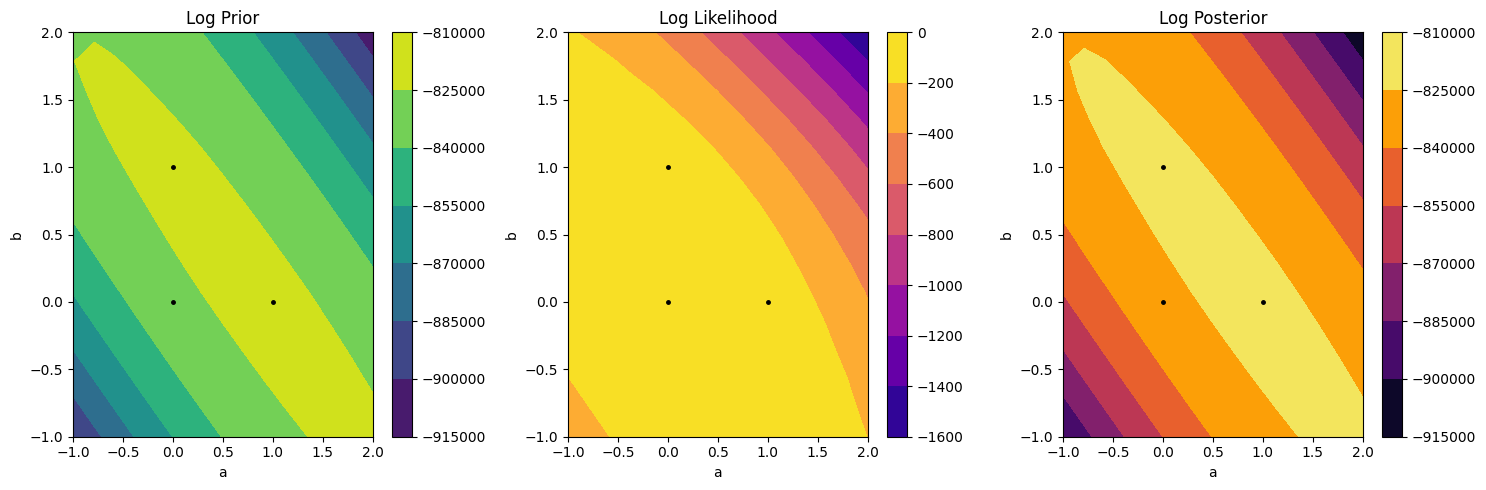

In [20]:
import matplotlib.pyplot as plt

def visualize_posterior_density(model, test_loader, samples, prior_std=1.0, device="cuda", grid_size=15):
    """
    Visualisation de la densité du posterior log-density, log-likelihood et log-prior dans 
    un sous-espace affine de paramètres défini par trois échantillons HMC.

    Parameters:
        model (torch.nn.Module): Modèle PyTorch
        test_loader (torch.utils.data.DataLoader): Dataloader pour évaluer les métriques
        samples (list of torch.Tensor): Liste contenant au moins 102 poids échantillonnés via HMC
        prior_std (float): Écart-type du prior
        device (str): "cuda" ou "cpu"
        grid_size (int): Nombre de points dans chaque dimension pour la visualisation
    """
    # Sélection des trois échantillons de poids définissant l’espace affine
    tier = int(len(samples) / 3)
    w1, w2, w3 = samples[0], samples[10], samples[60]

    # Génération des coefficients a et b dans [0,1]
    a_vals = np.linspace(-1, 2, grid_size)
    b_vals = np.linspace(-1, 2, grid_size)
    
    # Matrices pour stocker les valeurs des métriques
    log_priors = np.zeros((grid_size, grid_size))
    log_likelihoods = np.zeros((grid_size, grid_size))
    log_posteriors = np.zeros((grid_size, grid_size))

    # Parcours de la grille 2D
    for i, a in enumerate(a_vals):
        for j, b in enumerate(b_vals):
            # Interpolation des poids selon la formule donnée
            w_interp = [(w1_k * a + w2_k * b + w3_k * (1 - a - b)) for w1_k, w2_k, w3_k in zip(w1, w2, w3)]
            
            # Appliquer les poids interpolés au modèle
            set_model_params(model, w_interp)
            
            # Calculer les métriques
            metrics = compute_dataset_log_prob(model, test_loader, prior_std=prior_std, device=device)
            
            # Stocker les valeurs
            log_priors[i, j] = metrics["log_prior"]
            log_likelihoods[i, j] = metrics["log_likelihood"]
            log_posteriors[i, j] = metrics["log_posterior"]

    # Création des figures
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Création des grilles pour affichage
    A, B = np.meshgrid(a_vals, b_vals)

    # Log Prior
    ax = axes[0]
    contour = ax.contourf(A, B, log_priors.T, cmap="viridis")
    fig.colorbar(contour, ax=ax)
    ax.set_title("Log Prior")
    ax.set_xlabel("a")
    ax.set_ylabel("b")

    # Ajouter des points distinctifs : (0, 0), (1, 0) et (0, 1)
    ax.plot(0, 0, 'k.', markersize=5)  # Point noir pour (0, 0)
    ax.plot(1, 0, 'k.', markersize=5)  # Point noir pour (1, 0)
    ax.plot(0, 1, 'k.', markersize=5)  # Point noir pour (0, 1)

    # Log Likelihood
    ax = axes[1]
    contour = ax.contourf(A, B, log_likelihoods.T, cmap="plasma")
    fig.colorbar(contour, ax=ax)
    ax.set_title("Log Likelihood")
    ax.set_xlabel("a")
    ax.set_ylabel("b")

    # Ajouter des points distinctifs : (0, 0), (1, 0) et (0, 1)
    ax.plot(0, 0, 'k.', markersize=5)  # Point noir pour (0, 0)
    ax.plot(1, 0, 'k.', markersize=5)  # Point noir pour (1, 0)
    ax.plot(0, 1, 'k.', markersize=5)  # Point noir pour (0, 1)

    # Log Posterior
    ax = axes[2]
    contour = ax.contourf(A, B, log_posteriors.T, cmap="inferno")
    fig.colorbar(contour, ax=ax)
    ax.set_title("Log Posterior")
    ax.set_xlabel("a")
    ax.set_ylabel("b")

    # Ajouter des points distinctifs : (0, 0), (1, 0) et (0, 1)
    ax.plot(0, 0, 'k.', markersize=5)  # Point noir pour (0, 0)
    ax.plot(1, 0, 'k.', markersize=5)  # Point noir pour (1, 0)
    ax.plot(0, 1, 'k.', markersize=5)  # Point noir pour (0, 1)

    plt.tight_layout()
    plt.show()


# Supposons que `samples` soit une liste de 102 poids obtenus via HMC
visualize_posterior_density(model, test_loader, samples, prior_std=prior_std, device=device)
